In [155]:
import midi_manipulation
import numpy as np

In [156]:
f = 'Naruto Shippuden OP 16 COMP.mid'
song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
print np.shape(song)

(1072, 156)


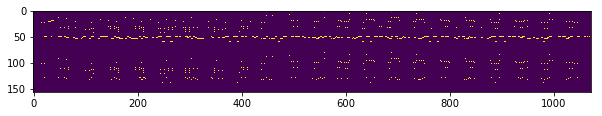

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
plt.imshow(song.T)

In [158]:
import tensorflow as tf

lowest_note = midi_manipulation.lowerBound
highest_note = midi_manipulation.upperBound
note_range = highest_note-lowest_note
print(note_range)

num_timesteps  = 100 #Timesteps in Music
n_visible      = 2*note_range*num_timesteps  #Num Visible Layers
n_hidden       = 300 #Num Hidden Layers
print(n_visible)

num_epochs = 400  #Num Epoch itterations
batch_size = 50   #Num Batch Size
lr         = tf.constant(0.100, tf.float32) #Learning rate, just messed around with it.

x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

78
15600


In [159]:
#This function lets us easily sample from a vector of probabilities
def sample(probs):
    #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

from tensorflow.python.ops import control_flow_ops

#This function runs the gibbs chain.
def gibbs_sample(k):
#    x_log = []   #this is for testing purposes to see if iterations change (or converge?)   

    def gibbs_step(count, k, xk):
        hk = sample(tf.nn.relu(tf.matmul(xk, W) + bh)) #Propagate the visible values to sample the hidden values
        xk = sample(tf.nn.relu(tf.matmul(hk, tf.transpose(W)) + bv)) #Propagate the hidden values to sample the visible values
        return count+1, k, xk

#    ct = tf.constant(0) #counter
#    [_, _, x_sample] = control_flow_ops.while_loop(lambda count, num_iter, *args: count < num_iter,
#                                         gibbs_step, [ct, tf.constant(k), x])
    
    ct = 0
    while ct < k:
        [ct, k, x_sample] = gibbs_step(ct,k, x) 
#        x_log.append(x_sample)    
        print('gibbs iteration {}'.format(ct))

    # Stops tensorflow from propagating gradients back through the gibbs step
    x_sample = tf.stop_gradient(x_sample)
    return x_sample #x_log

In [160]:
#The sample of x
x_sample = gibbs_sample(1)
#The sample of the hidden nodes, starting from the visible state of x
h = sample(tf.nn.relu(tf.matmul(x, W) + bh))
#The sample of the hidden nodes, starting from the visible state of x_sample
h_sample = sample(tf.nn.relu(tf.matmul(x_sample, W) + bh))

#Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
size_bt = tf.cast(tf.shape(x)[0], tf.float32)
W_adder  = tf.multiply(lr/size_bt, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
bv_adder = tf.multiply(lr/size_bt, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
bh_adder = tf.multiply(lr/size_bt, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
#When we do sess.run(updt), TensorFlow will run all 3 update steps
updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]

In [161]:
from tqdm import tqdm

sess = tf.InteractiveSession()

#Training
#initialize the variables of the model
init = tf.global_variables_initializer()
sess.run(init)

#Run through all of the training data num_epochs times
for epoch in tqdm(range(num_epochs)):

    #Reshape the song so that each training example is a vector with num_timesteps x 2*note_range elements
    song = song[:int(np.floor(song.shape[0]/num_timesteps))*num_timesteps]
#    print(np.shape(song))
    songflat = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
#    print(np.shape(songflat))

    #Train the RBM on batch_size examples at a time
    for i in range(1, len(songflat), batch_size):
        tr_x = songflat[i:i+batch_size]
        sess.run(updt, feed_dict={x: tr_x})

100%|██████████| 400/400 [01:01<00:00,  6.86it/s]


In [162]:
cnt = 0

In [163]:
#Run a gibbs chain where the visible nodes are initialized to 0
improv = gibbs_sample(1).eval(session=sess, feed_dict={x: np.zeros((1, n_visible))}) #try 10 or more in gibbs_sample

#Here we reshape the vector to be time x notes, and then save the vector as a midi file
print("BUILDING YOUR SONG NUMBER "+str(cnt))
S = np.reshape(improv[0,:], (num_timesteps, 2*note_range))
midi_manipulation.noteStateMatrixToMidi(S, "generated_chord_{}".format(cnt))
cnt = cnt + 1

#Repeat running this cell to get more and more improvisations (no need for training again)

BUILDING YOUR SONG NUMBER 0


In [164]:
import music21 as mus
s = mus.converter.parse('generated_chord_' + str(cnt-1) + '.mid')
#s.show()

In [165]:
s.show('midi')